## Objective

This notebook aims to demonstrate the best practices of detecting fraudulent transactions for credit cards. It will contain steps for data cleaning, feature engineering, data preprocessing, model development and evaluation.

Modelling approach adopted largely from: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html

## Background

While there are no definite taxonomy on credit card fraud types, there are more common patterns that happen. These are: 
1) **card-present frauds**: physical cards are needed and transactions happen at Point-of-Sale or ATMs;frauds due to stolen, lost, counterfieted cards or cards not received.
2) **card-not-present frauds**: payments performed on the internet by phone or email; frauds due to illegally obtained credentials (card number, expiration date, security code and personal billing information) from data breaches, phishing, scam text or calls.

In Europe, the majority (69% to 79%) of card fraud value comes from card-not-present frauds.

In order to detect fraud cases, sophisticated credit card fraud detection system has been developed. The Machine Learning Group (Université Libre de Bruxelles - ULB) ([link](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_2_Background/FDS.html)) has made a convenient representation here: 
<img src="../images/fraud_detection_system.png" alt="Drawing" style="width: 500px;"/>
<br>
The predictive model that is being developed would fit into fraud detection system as the Data Driven Model component highlighted in the red box.

## Challenges
There are challenges for predicting credit card frauds. The Machine Learning Group (Université Libre de Bruxelles - ULB) ([link](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_2_Background/MachineLearningForFraudDetection.html)) has listed some below:
1) **Class imbalance**: Usually transactional data contains much more legitimate ones than fraud (<1%). Most learning algos do not handle imbalances well, so need to do additional strategies like sampling or loss weighting.
2) **Concept drift**: Transaction and fraud patterns changes over time and fraudsters develop new techniques.
3) **Near real-time requirements**: Classification times as low as tens of milliseconds may be required.
4) **Sequential modeling**: Each terminal and/or customers would generate data sequentially with its own unique characteristics. Models need to be able to account for these.
5) **Performance measures**: Accuracy and/or AUROC not sufficient. Other metrics such as F-1 Score, Recall, Precision and Area under the PR Curve could be more suitable.

## Metrics
For fraud detection, the aim is to maximise recall while minimising false positives. To de-conflict this, one way is to assess the accuracy using the recall and false positive rates at all possible decision thresholds using the **AUROC**. In order to circumvent the weakness of AUROC on imbalanced dataset (i.e. focuses on recall; false positive rates does not decrease drastically when total real negative values is high), **Average Precision** can be used, which highlights the performance when keeping precision high. Another metric that would be used is the **Card Precision @ Top-k** which asseses the average daily precision of the system, assuming that a maximum of k cards can be checked by investigators on a daily basis, thus giving a more concrete metric.

For AUROC and Average Precision, the metrics functions from sklearn library will be used. For Card Precision @ Top-k, the following will be implmented:

In [ ]:
def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):
    
    days = sorted(list(predictions_df["trans_date_trans_time_days"].unique()))
    
    detected_compromised_cards_all = []
    card_precision_top_k_daily = []
    no_compromised_cards_daily = []
    
    for day in days:
        df_day = predictions_df[predictions_df['trans_date_trans_time_days']==day]
        df_day = df_day[['predictions', 'cc_num', 'is_fraud']]
        
        # Removing previously detected cards
        df_day = df_day[df_day.cc_num.isin(list_detected_compromised_cards)==False]
        no_compromised_cards_daily.append(len(df_day[df_day.is_fraud==1]["cc_num"].unique()))
        
        # Calculate card precision top k for the day
        df_day = df_day.groupby('cc_num').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
        df_day_top_k = df_day.head(top_k)
        detected_compromised_cards_day=list(df_day_top_k[df_day_top_k.is_fraud==1]["cc_num"])
        card_precision_top_k_daily.append(len(detected_compromised_cards_day) / top_k)
        
        # Add the day's detected fraud cards to the list
        if remove_detected_compromised_cards:
            detected_compromised_cards_all.extend(detected_compromised_cards_day)
    
    card_precision_top_k = np.array(card_precision_top_k_daily).mean()
    
    return no_compromised_cards_daily, detected_compromised_cards_all, card_precision_top_k
    

# Dataset

For this exercise, data is extracted from Kaggle ([link](https://www.kaggle.com/datasets/dermisfit/fraud-transactions-dataset?resource=download)) and has the following columns:

1) trans_date_trans_time: The date and time of the transaction.
2) cc_num: credit card number.
3) merchant: Merchant who was getting paid.
4) category: In what area does that merchant deal.
5) amt: Amount of money in American Dollars.
6) first: first name of the card holder.
7) last: last name of the card holder.
8) gender: Gender of the cardholder.Just male and female!
9) street: Street of card holder residence
10) city: city of card holder residence
11) state: state of card holder residence
12) zip: ZIP code of card holder residence
13) lat: latitude of card holder
14) long: longitude of card holder
15) city_pop: Population of the city
16) job: trade of the card holder
17) dob: Date of birth of the card holder
18) trans_num: Transaction ID
19) unix_time: Unix time which is the time calculated since 1970 to today.
20) merch_lat: latitude of the merchant
21) merch_long: longitude of the merchant
22) is_fraud: Whether the transaction is fraud (1) or not (0)



## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from geopy.distance import geodesic 

In [3]:
SEED=99

## Credit Card Fraud Dataset

In [4]:
df_transactions_raw = pd.read_csv("../data/fraudTrain.csv", index_col=0)
df_transactions_raw.info()

/home/aznor/miniconda3/envs/fraud/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [5]:
def basic_clean(df):
    df_final = df.copy()
    df_final["trans_date_trans_time"] = pd.to_datetime(df_final["trans_date_trans_time"])
    df_final["cc_num"] = df_final["cc_num"].astype("str")
    df_final["zip"] = df_final["zip"].astype("str")
    df_final["dob"] = pd.to_datetime(df_final["dob"],format="%Y-%m-%d")
    df_final = df_final.sort_values(by=["trans_date_trans_time"])
    
    return df_final

print(basic_clean(df_transactions_raw.head(1)).iloc[0], end="\n\n")
print(basic_clean(df_transactions_raw.head(1)).info())

trans_date_trans_time                 2019-01-01 00:00:18
cc_num                                   2703186189652095
merchant                       fraud_Rippin, Kub and Mann
category                                         misc_net
amt                                                  4.97
first                                            Jennifer
last                                                Banks
gender                                                  F
street                                     561 Perry Cove
city                                       Moravian Falls
state                                                  NC
zip                                                 28654
lat                                               36.0788
long                                             -81.1781
city_pop                                             3495
job                             Psychologist, counselling
dob                                   1988-03-09 00:00:00
trans_num     

In [6]:
df_transactions_clean = basic_clean(df_transactions_raw)

## Check the Test Set

In [14]:
df_test_raw = pd.read_csv("../data/fraudTest.csv", index_col=0)
df_test_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

In [16]:
df_test_clean = basic_clean(df_test_raw)
df_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  555719 non-null  datetime64[ns]
 1   cc_num                 555719 non-null  object        
 2   merchant               555719 non-null  object        
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   first                  555719 non-null  object        
 6   last                   555719 non-null  object        
 7   gender                 555719 non-null  object        
 8   street                 555719 non-null  object        
 9   city                   555719 non-null  object        
 10  state                  555719 non-null  object        
 11  zip                    555719 non-null  object        
 12  lat                    555719 non-null  floa

In [20]:
print("Test data date range is between: {0} to {1}".format(
    df_test_clean["trans_date_trans_time"].min(),
    df_test_clean["trans_date_trans_time"].max()
))

Test data date range is between: 2020-06-21 12:14:25 to 2020-12-31 23:59:34


## Conduct Basic EDA

In [22]:
neg, pos = np.bincount(df_transactions_clean["is_fraud"])
print(f"Total Training Data: {neg+pos}\nFraudulent Labels: {pos} ({round(100*(pos/(pos+neg)), 2)}% of Total)")

Total Training Data: 1296675
Fraudulent Labels: 7506 (0.58% of Total)


In [21]:
print("Train data date range is between: {0} to {1}".format(
    df_transactions_clean["trans_date_trans_time"].min(),
    df_transactions_clean["trans_date_trans_time"].max()
))

Train data date range is between: 2019-01-01 00:00:18 to 2020-06-21 12:13:37


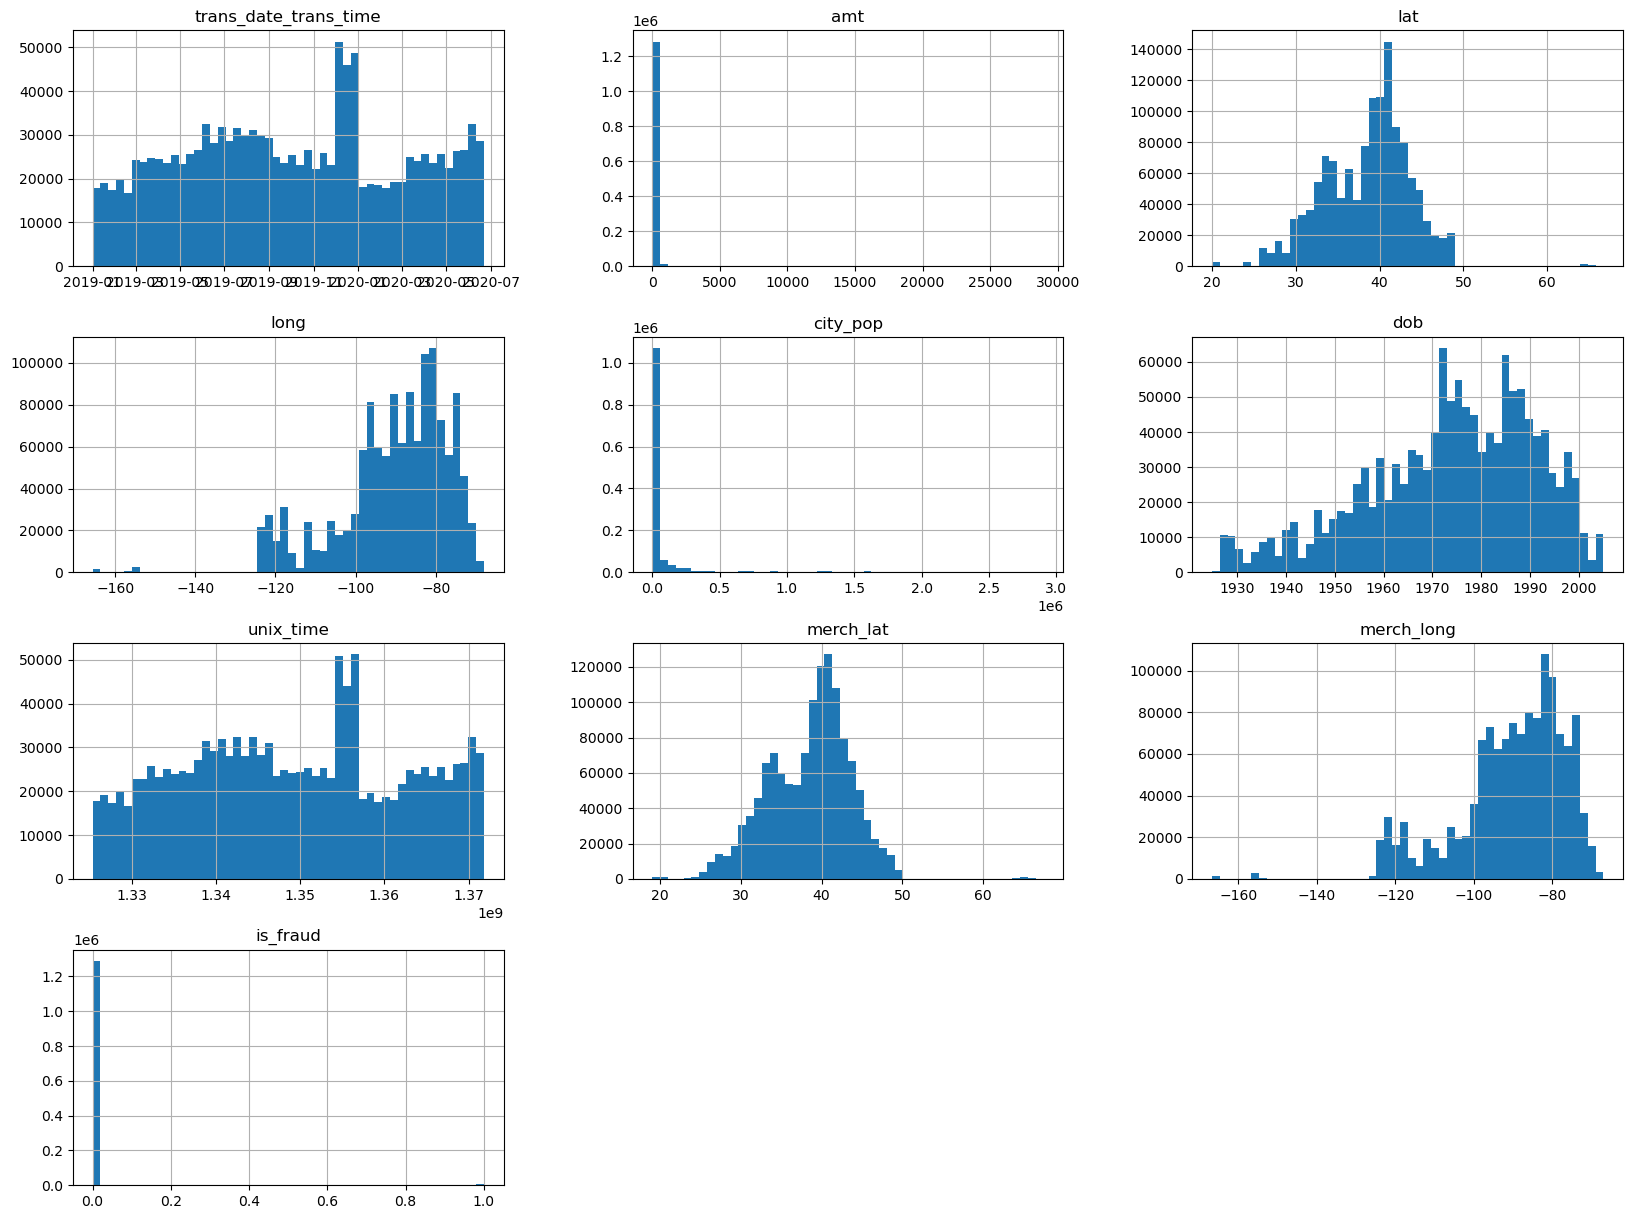

In [23]:
# examine the distribution of each numerical variable
%matplotlib inline
df_transactions_clean.hist(bins=50, figsize=(20,15))
plt.show()

In [24]:
# examine the labels and distribution of the categorical variable 
cat_cols = df_transactions_clean.select_dtypes(include=['object']).columns
for col_name in cat_cols:
    print(df_transactions_clean[col_name].value_counts(dropna=False, normalize=True), "\n\n")

571365235126           0.002408
4512828414983801773    0.002408
36722699017270         0.002405
213112402583773        0.002404
3545109339866548       0.002401
                         ...   
180097223252063        0.000005
4225628813173670       0.000005
501894933032           0.000005
4975457191020          0.000005
340187018810220        0.000005
Name: cc_num, Length: 983, dtype: float64 


fraud_Kilback LLC                       0.003396
fraud_Cormier LLC                       0.002814
fraud_Schumm PLC                        0.002803
fraud_Kuhn LLC                          0.002707
fraud_Boyer PLC                         0.002694
                                          ...   
fraud_Douglas, DuBuque and McKenzie     0.000598
fraud_Treutel-King                      0.000598
fraud_Medhurst, Labadie and Gottlieb    0.000585
fraud_Reichert-Weissnat                 0.000581
fraud_Hahn, Douglas and Schowalter      0.000561
Name: merchant, Length: 693, dtype: float64 


gas_transport    

In [25]:
# Examine cross-correlation between numerical variable and categorical variable of concern
df_temp = pd.concat(
    [
        df_transactions_clean[df_transactions_clean["is_fraud"] == 0],
        df_transactions_clean[df_transactions_clean["is_fraud"] == 1],
    ]
)

SAMPLE_N = 10000

fig = px.histogram(
    df_temp.sample(n=SAMPLE_N),
    title=f"Fraud for different amounts (n={SAMPLE_N} random samples)",
    x="amt",
    color="is_fraud",
    marginal="box",
)
fig.update_traces(opacity=0.75)
fig.update_layout(barmode="overlay")
fig.show()

## Feature Engineering

In [72]:
def get_risk_scores_rolling_window(merchant_transactions, delay_period, windows_size_days, feature="merchant"):
    
    # merchant_transactions is the grouped data frame
    merchant_transactions = merchant_transactions.sort_values('trans_date_trans_time')
    
    merchant_transactions.index = merchant_transactions["trans_date_trans_time"]
    
    # Get the number of fraud cases and the number of transactions in the delay period
    # Window parameter in .rolling() can be frequency strings if indexes are datetimelike
    NB_FRAUD_DELAY = merchant_transactions['is_fraud'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY = merchant_transactions['is_fraud'].rolling(str(delay_period)+'d').count()
    
    # Calculate the number of fraud cases and the number of transactions in each window size determined 
    for window_size in windows_size_days:
        
        # First get the numbers in the delay + window periods combined
        NB_FRAUD_DELAY_WINDOW = merchant_transactions['is_fraud'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW = merchant_transactions['is_fraud'].rolling(str(delay_period+window_size)+'d').count()
        
        # Second get the numbers in the window periods only
        NB_FRAUD_WINDOW = NB_FRAUD_DELAY_WINDOW - NB_FRAUD_DELAY
        NB_TX_WINDOW = NB_TX_DELAY_WINDOW - NB_TX_DELAY
        
        # Calculate the risk: proportion of fraud to all transactions
        RISK_WINDOW = NB_FRAUD_WINDOW / NB_TX_WINDOW
        
        # Add the risk scores into the dataset
        merchant_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW'] = list(NB_TX_WINDOW)
        merchant_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW'] = list(RISK_WINDOW)
        
    merchant_transactions.index=merchant_transactions["trans_num"]
    
    merchant_transactions.fillna(0,inplace=True)
    
    return merchant_transactions


def prepare_x(df):
    df_final = df.copy()
    df_final = df_final.sort_values('trans_date_trans_time').reset_index(drop=True)
    
    # Add date fields from start date
    df_final["trans_date_trans_time_seconds"] = [x.total_seconds() for x in (df_final["trans_date_trans_time"] - pd.to_datetime(df_final["trans_date_trans_time"].min().strftime('%Y-%m-%d')))]
    df_final["trans_date_trans_time_days"] = [x.days for x in (df_final["trans_date_trans_time"] - df_final["trans_date_trans_time"].min())]
    
    # Create features
    df_final["hour_of_day"] = df_final["trans_date_trans_time"].dt.strftime('%H')
    df_final["day_of_week"] = df_final["trans_date_trans_time"].dt.strftime('%w')
    df_final["age_months"] = ((df_final["trans_date_trans_time"] - df_final["dob"])/np.timedelta64(1, 'M')).astype(int)
    # Note: The function in apply takes the grouped dataframe as the argument, then the rolling method takes the aggregate for each value in a window
    df_final["cc_num_transactions_1day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").count())["amt"]
    df_final["cc_num_transactions_7day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").count())["amt"]
    df_final["cc_num_transactions_30day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").count())["amt"]
    df_final["cc_avg_amt_1day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").mean())["amt"]
    df_final["cc_avg_amt_7day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").mean())["amt"]
    df_final["cc_avg_amt_30day"] = df_final.groupby("cc_num").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").mean())["amt"]
    df_final["merchant_num_transactions_1day"] = df_final.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").count())["amt"]
    df_final["merchant_num_transactions_7day"] = df_final.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").count())["amt"]
    df_final["merchant_num_transactions_30day"] = df.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").count())["amt"]
    df_final["merchant_avg_amt_1day"] = df_final.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("1d", on="trans_date_trans_time").mean())["amt"]
    df_final["merchant_avg_amt_7day"] = df_final.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("7d", on="trans_date_trans_time").mean())["amt"]
    df_final["merchant_avg_amt_30day"] = df_final.groupby("merchant").apply(lambda x: x[["trans_date_trans_time", "amt"]].rolling("30d", on="trans_date_trans_time").mean())["amt"]
    df_final["holder_merchant_geodist_km"] = [geodesic((x[0], x[1]), (x[2], x[3])).km for x in zip(df_final["lat"], df_final["long"], df_final["merch_lat"], df_final["merch_long"])]
    
    # Get risk scores of merchants
    df_final = df_final.groupby('merchant').apply(lambda x: get_risk_scores_rolling_window(x, delay_period=7, windows_size_days=[1,7,30], feature="merchant"))
    df_final = df_final.sort_values('trans_date_trans_time').reset_index(drop=True)
    
    return df_final
    

print(prepare_x(df_transactions_clean.head(1)).iloc[0], end="\n\n")
print(prepare_x(df_transactions_clean.head(1)).info())

trans_date_trans_time                           2019-01-01 00:00:18
cc_num                                             2703186189652095
merchant                                 fraud_Rippin, Kub and Mann
category                                                   misc_net
amt                                                            4.97
first                                                      Jennifer
last                                                          Banks
gender                                                            F
street                                               561 Perry Cove
city                                                 Moravian Falls
state                                                            NC
zip                                                           28654
lat                                                         36.0788
long                                                       -81.1781
city_pop                                        

In [73]:
df_final = prepare_x(df_transactions_clean)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 46 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   trans_date_trans_time            1296675 non-null  datetime64[ns]
 1   cc_num                           1296675 non-null  object        
 2   merchant                         1296675 non-null  object        
 3   category                         1296675 non-null  object        
 4   amt                              1296675 non-null  float64       
 5   first                            1296675 non-null  object        
 6   last                             1296675 non-null  object        
 7   gender                           1296675 non-null  object        
 8   street                           1296675 non-null  object        
 9   city                             1296675 non-null  object        
 10  state                         

## Save to Local File System

In [74]:
DIR_OUTPUT = "../data/transformed"

In [75]:
if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = dt.datetime.strptime("2019-01-01", "%Y-%m-%d")

for day in range(df_final["trans_date_trans_time_days"].max()+1):
    
    transactions_day = df_final[df_final["trans_date_trans_time_days"]==day].sort_values('trans_date_trans_time_seconds')
    
    date = start_date + dt.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    transactions_day.to_pickle(DIR_OUTPUT+"/"+filename_output)

### [TO DO] Add validation strategies using prequential validation methods. Use 3 months for validation and 6 months of training sets: If the validation scores and the test scores are the same, then there are no issues.

In [209]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=28,delta_delay=7,delta_test=7):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.trans_date_trans_time>=start_date_training) &
                               (transactions_df.trans_date_trans_time<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be compromised after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known defrauded customers from the training set
    known_defrauded_customers = set(train_df[train_df.is_fraud==1].cc_num)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.trans_date_trans_time_days.min()
    
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.trans_date_trans_time_days==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        test_df_day_delay_period = transactions_df[transactions_df.trans_date_trans_time_days==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.is_fraud==1].cc_num)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)
        
        test_df_day = test_df_day[~test_df_day.cc_num.isin(known_defrauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('trans_num')
    test_df=test_df.sort_values('trans_num')
    
    return (train_df, test_df)

In [ ]:
def prequentialSplit(transactions_df, start_date_training, n_folds, delta_train, delta_delay, delta_assessment):
    
    prequential_split_indices = []
        
    # For each fold
    for fold in range(n_folds):
        
        # Shift back start date for training by the fold index times the assessment period (delta_assessment)
        start_date_training_fold = start_date_training - datetime.timedelta(days = fold * delta_assessment)
        
        # Get the training and test (assessment) sets
        (train_df, test_df) = get_train_test_set(
            transactions_df,
            start_date_training = start_date_training_fold,
            delta_train = delta_train,
            delta_delay = delta_delay,
            delta_test = delta_assessment
        )
    
        # Get the indices from the two sets, and add them to the list of prequential splits
        indices_train = list(train_df.index)
        indices_test = list(test_df.index)
        
        prequential_split_indices.append((indices_train, indices_test))
    
    return prequential_split_indices

In [ ]:
def card_precision_top_scorer(y_true, y_pred, top_k, transactions_df):
    
    predictions_df = transactions_df.iloc[y_true.index.values].copy()
    predictions_df['predictions'] = y_pred
    
    _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
    
    return mean_card_precision_top_k

transactions_df_scorer=transactions_df[['cc_num', 'is_fraud','trans_date_trans_time']]

# Make scorer using card_precision_top_k_custom
card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_scorer, 
                                                     needs_proba = True, 
                                                     top_k = 100, 
                                                     transactions_df = transactions_df_scorer)

### [TO DO] Add model experimentation using Logistic Regression, Decision Tree, Random Forest and XGBoost

### [TO DO] Add model experimentation using, baseline bagging, balanced rf, baseline rf, balanced rf, baseline xgboost, weighted xgboost 

### [TO DO] Add experimentation using NN, CNN, LSTM, LSTM with Attention and GRU

## Baseline Fraud Detection System

In [76]:
DIR_INPUT = "../data/transformed"

In [77]:
# Use four weeks for training, one week of delay and one week for testing
BEGIN_DATE = "2019-03-06" 
END_DATE = "2019-04-17"


def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final = df_final.sort_values('trans_num')
    df_final.reset_index(drop=True,inplace=True)
    
    return df_final

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.is_fraud.sum()))


Load  files
CPU times: user 217 ms, sys: 19.9 ms, total: 237 ms
Wall time: 249 ms
96597 transactions loaded, containing 631 fraudulent transactions


In [210]:
start_date_training = datetime.datetime.strptime(BEGIN_DATE, "%Y-%m-%d")
end_date_training = start_date_training+datetime.timedelta(days=28-1)
start_date_test = start_date_training+datetime.timedelta(days=28+7)
end_date_test = start_date_training+datetime.timedelta(days=28+7+7-1)

print(start_date_training)
print(end_date_training)
print(start_date_test)
print(end_date_test)

2019-03-06 00:00:00
2019-04-02 00:00:00
2019-04-10 00:00:00
2019-04-16 00:00:00


In [219]:
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=28,delta_delay=7,delta_test=7)

In [220]:
train_df.shape

(63210, 46)

In [221]:
train_df[train_df.is_fraud==1].shape

(449, 46)

In [222]:
test_df.shape

(15051, 46)

In [223]:
test_df[test_df.is_fraud==1].shape

(78, 46)

## Model Training

In [225]:
transactions_df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_date_trans_time_seconds',
       'trans_date_trans_time_days', 'hour_of_day', 'day_of_week',
       'age_months', 'cc_num_transactions_1day', 'cc_num_transactions_7day',
       'cc_num_transactions_30day', 'cc_avg_amt_1day', 'cc_avg_amt_7day',
       'cc_avg_amt_30day', 'merchant_num_transactions_1day',
       'merchant_num_transactions_7day', 'merchant_num_transactions_30day',
       'merchant_avg_amt_1day', 'merchant_avg_amt_7day',
       'merchant_avg_amt_30day', 'holder_merchant_geodist_km',
       'merchant_NB_TX_1DAY_WINDOW', 'merchant_RISK_1DAY_WINDOW',
       'merchant_NB_TX_7DAY_WINDOW', 'merchant_RISK_7DAY_WINDOW',
       'merchant_NB_TX_30DAY_WINDOW', 'merchant_RISK_30DAY_WINDOW'],
      dtype='object')

In [227]:
target = "is_fraud"

In [249]:
input_features = [
    "amt", "city_pop", "hour_of_day", "day_of_week", "age_months", "cc_num_transactions_1day", "cc_num_transactions_7day",
    "cc_num_transactions_30day", "cc_avg_amt_1day", "cc_avg_amt_7day", "cc_avg_amt_30day",
    "merchant_num_transactions_1day", "merchant_num_transactions_7day", "merchant_num_transactions_30day",
    "merchant_avg_amt_1day", "merchant_avg_amt_7day", "merchant_avg_amt_30day", "holder_merchant_geodist_km",
    "merchant_NB_TX_1DAY_WINDOW", "merchant_RISK_1DAY_WINDOW", "merchant_NB_TX_7DAY_WINDOW", 
    "merchant_RISK_7DAY_WINDOW", "merchant_NB_TX_30DAY_WINDOW", "merchant_RISK_30DAY_WINDOW"
]

In [250]:
def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])
    
    return (train,test)

In [251]:
def fit_model_and_get_predictions(classifier, train_df, test_df, 
                                  input_features, output_feature="is_fraud",scale=True):

    # By default, scales input data
    if scale:
        (train_df, test_df)=scaleData(train_df,test_df,input_features)
    
    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

In [255]:
classifiers_dictionary={'Logistic regression': LogisticRegression(random_state=0), 
                        'Decision tree with depth of two':DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':DecisionTreeClassifier(random_state=0), 
                        'Random forest':RandomForestClassifier(random_state=0,n_jobs=-1),
                        'XGBoost':XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
    
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, 
                                                                                  input_features=input_features,
                                                                                output_feature=target)
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions


/home/aznor/miniconda3/envs/fraud/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[01:34:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [258]:
def performance_assessment(predictions_df, output_feature='is_fraud', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average Precision'])
    
    for top_k in top_k_list:
    
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances

In [264]:
def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test',
                                            top_k_list=[100]):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        #predictions_df['predictions']=0.5 for a model randomly choosing 
        
        performances_model=performance_assessment(predictions_df, output_feature='is_fraud', 
                                                   prediction_feature='predictions', top_k_list=top_k_list)
        performances_model.index=[classifier_name]
        
        performances=performances.append(performances_model)
        
    return performances

In [262]:
# performances on test set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, test_df, 
                                                        type_set='test', 
                                                        top_k_list=[100])
df_performances

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.971,0.641,0.013
Decision tree with depth of two,0.838,0.420,0.013
Decision tree - unlimited depth,0.794,0.364,0.013
Random forest,0.970,0.872,0.013
XGBoost,0.995,0.918,0.013


## Summary of Baseline Models
- Model was able to learn some useful fraud patterns from the training data - AUROC on the test set is >0.5 for all classifiers. Boosting model provides the best performance - based on precision alone.
- Based on Card Precision@100, around 1% of the cards with the highest fraudulent scores were compromised, if one each day, 100 transactions are being investigated. This is double the percentage of fraud in the test set (0.5%)

## 

## Notes on Metrics
<ins> **Threshold-based Metrics** </ins> <br>
For Fraud detection, there is currently no concensus in the literature on a single metric that is the best one. While a popular approach for a balanced dataset is the **Mean Misclassification Error or Error Rate (1 - accuracy)**, for an **imbalanced dataset** it presents problems such as giving the **same weight to false negatives and false positives** which is a problem for applications such as fraud detection (more costly for false negatives) or medical diagnosis (more costly for false positives). in addition, for models trained on an imbalanced dataset, the model usually fails to generalize well to the minority class - so recall and sensitivity is poor - and this may not be reflected by simply using the Mean Misclassification Error.

For fraud detection problems, as getting **false negatives is typically more costly than getting a false positive** - missing a fraud transaction results in missing other fraud transactions from the same card and fraudulent transactions may require reimbursements or costs related to dealing with the issue or costs on the company's reputation. An alternative is to use **Weighted Loss** - i.e. multiplying the false positives and the false negatives with an individual weight.

Some better approaches are:
1) True Positive Rate (Recall) - proportion of all frauds correctly identified as fraud

2) Precision - proportion of correct fraud cases that were identified as fraud by the model 

3) F1-Score is the harmonic mean of the Precision and Recall scores

In general, a fully automated system should focus on having higher precision while a system with second layer human verification, higher recall should be favoured.


<ins> **Threshold-free Metrics** </ins> <br>
Does not require a threshold to be set - allows to assess the overall performance score, across different thresholds. Most common metrics are: <br>
1) **AUROC** - plot of **Recall vs False Positive Rate** (as threshold decreases, and false positive rates increases marginally, recall typically increases but rate of increase will decrease). First point is predicting all as not fraud (True Positives = 0, False Positives = 0). Last point of the curve predicts all transactions as fraudulant (False Positives = all non-fraud misclassified as fraud, True Positives = All fraud detected). The AUC ROC can be interpreted as the probability that the scores given by a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. Their interest for fraud detection is however limited since an **important goal of fraud detection is to keep the FPR very low**. The proportion of transactions that can be manually checked is in fact closer to 0.1% so any FPR higher than 0.001 is already too high.
2) **AUPR** - plot of **Precision vs Recall** (as threshold decreases, recall increases and precision decreases). Puts in classifiers with high recall and precision. Usually summarised by the Average Precision: Across the different threshold, get the sum of the product of P*(Current Recall - Previous Recall). Properties: **Non-monotonic, AUC has no statistical interpretation and performance of random classifier depends on the class imbalance**.

Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

<ins> **Precision Top-k Metrics** </ins> <br>
Finally, an operationally more relevant metrics would be the Precision Top-k and Card Precision Top-k Metrics.
1) **Precision Top-k** - the average of precision scores (number of fraud transactions from top-k highest probabilities / |k| ).
2) **Card Precision Top-k** - the average of precision scores (number of fraudulent cards from top-k highest probablities / |k|), excluding the cards previously detected to be fraudulent (i.e. from previous days in the test set).